In [1]:
import os
import joblib
import string
import re
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

dataset_path = os.path.realpath(os.path.join(os.path.dirname(__name__), '..', 'app', 'static', 'uploads', 'dataset.csv'))
X_train_path = os.path.realpath(os.path.join(os.path.dirname(__name__), '..', 'app', 'static', 'uploads', 'X_train.pkl'))
encoder_path = os.path.realpath(os.path.join(os.path.dirname(__name__), '..', 'app', 'static', 'uploads', 'encoder.pkl'))
model_path = os.path.realpath(os.path.join(os.path.dirname(__name__), '..', 'app', 'static', 'uploads', 'model.pkl'))

In [2]:
# Fungsi Untuk preprocessing
class TextCleaner:
    def __init__(self):
        print('===== Preprocessing =====')
        self.stemmer = StemmerFactory().create_stemmer()
        stopword_factory = StopWordRemoverFactory()
        self.combined_stopwords = set(stopword_factory.get_stop_words()).union(set(stopwords.words('english')))

    def clean_text(self, text):
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text

    def preprocess_text(self, text) -> str:
        text = self.clean_text(text).lower()
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in self.combined_stopwords]
        stemmed = [self.stemmer.stem(word) for word in tokens]
        return ' '.join(stemmed)

In [3]:
data = pd.read_csv(dataset_path)
data_csv = pd.read_csv(dataset_path)
documents_sentiment = list(data_csv['label'])

try:
    vectorizer = joblib.load(X_train_path)
    X = vectorizer.transform(data['comment'])
except FileNotFoundError:
    
    text_cleaner = TextCleaner()
    cleaned_data = [text_cleaner.preprocess_text(text) for text in data_csv['comment']]
    
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(cleaned_data)
    joblib.dump(vectorizer, X_train_path)
    

try:
    encoder = joblib.load(encoder_path)
    y = encoder.transform(data['label'])
except FileNotFoundError:
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(documents_sentiment)
    
    joblib.dump(encoder, encoder_path)
    

# Pisahkan data menjadi 80 banding 20 (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

try:
    model = joblib.load(model_path)
except FileNotFoundError:
    model = SVC(kernel='linear')
    model.fit(X_train, y_train)
    joblib.dump(model, model_path)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
misclassification_count = sum(y_test != y_pred)
misclassification_rate = misclassification_count / len(y_test) * 100

# Perhitungan confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

d:\programming\ran-svm\.venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\programming\ran-svm\.venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\programming\ran-svm\.venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.1 when using version 1.5.2. This might lea

Hasil Perhitungan Akurasi

Accuracy: 0.9700
F1-Score: 0.9700
Recall: 0.9700
Precision: 0.9702
Misclassification Count: 6
Misclassification Rate: 3.00%


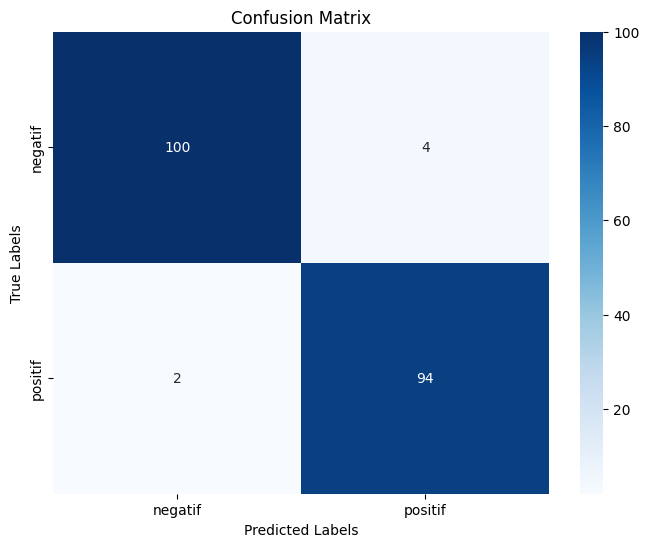

In [4]:
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print("Misclassification Count:", misclassification_count)
print("Misclassification Rate: {:.2f}%".format(misclassification_rate))

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()